In [1]:
import re
import random
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment', None)

import pandas as pd
import nltk 
import numpy as np
import re

from nltk.stem import wordnet                                  # to perform lemmitization
from sklearn.feature_extraction.text import CountVectorizer    # to perform bow
from sklearn.feature_extraction.text import TfidfVectorizer    # to perform tfidf
from nltk import pos_tag                                       # for parts of speech
from sklearn.metrics import pairwise_distances                 # to perfrom cosine similarity
from nltk import word_tokenize                                 # to create tokens
from nltk.corpus import stopwords                              # for stop words
from keras.backend import clear_session    
     
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, SimpleRNN

# **Loading Data and Preliminary Analysis**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
data=pd.read_csv("/content/gdrive/MyDrive/Mental_Health_FAQ1.csv",nrows=20)
     

In [4]:
pd.set_option('display.max_colwidth', None)
data.head()

,Question_ID,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that disrupt a person's thoughts emotions relationships and daily functioning.
1,2110618,Who does mental illness affect?,Mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background.
2,9434130,What are some of the warning signs of mental illness?,Symptoms of mental health disorders vary depending on the type and severity of the condition.
3,7657263,Can people with mental illness recover?,"When healing from mental illness, early identification and treatment are of vital importance."
4,1619387,What should I do if I know someone who appears to have the symptoms of a mental disorder?,We encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional.


In [5]:
# data preprocessing 

for i in range(data.shape[0]):
  data['Answers'][i]=re.sub(r'\n', ' ',data['Answers'][i])
  data['Answers'][i]=re.sub(r'\(', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r'\)', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r',', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r'-', '',data['Answers'][i])
  data['Answers'][i]=re.sub(r'/', '',data['Answers'][i])
  data['Answers'][i]=re.sub(r'â€™', '',data['Answers'][i])

In [6]:
import re
#preprocessing questions and answers.
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [33]:
def preprocess(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\"’°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


In [6]:
data['processed_question'] = data['Questions'].apply(preprocess)
data['processed_answer'] = data['Answers'].apply(preprocess)
data.head()

NameError: ignored

In [35]:
data.head()

,Question_ID,Questions,Answers,processed_question,processed_answer
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that disrupt a person's thoughts emotions relationships and daily functioning.,what does it mean to have a mental illness?,mental illnesses are health conditions that disrupt a person is thoughts emotions relationships and daily functioning.
1,2110618,Who does mental illness affect?,Mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background.,who does mental illness affect?,mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background.
2,9434130,What are some of the warning signs of mental illness?,Symptoms of mental health disorders vary depending on the type and severity of the condition.,what are some of the warning signs of mental illness?,symptoms of mental health disorders vary depending on the type and severity of the condition.
3,7657263,Can people with mental illness recover?,When healing from mental illness early identification and treatment are of vital importance.,can people with mental illness recover?,when healing from mental illness early identification and treatment are of vital importance.
4,1619387,What should I do if I know someone who appears to have the symptoms of a mental disorder?,We encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional.,what should i do if i know someone who appears to have the symptoms of a mental disorder?,we encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional.


In [7]:

pairs=[]

for i in range(data.shape[0]):
  pairs.append(((data['Questions'][i]),data['Answers'][i]))
     

In [8]:

pairs                                     # questions

[('What does it mean to have a mental illness?',
  "Mental illnesses are health conditions that disrupt a person's thoughts emotions relationships and daily functioning."),
 ('Who does mental illness affect?',
  'Mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background.'),
 ('What are some of the warning signs of mental illness?',
  'Symptoms of mental health disorders vary depending on the type and severity of the condition.'),
 ('Can people with mental illness recover?',
  'When healing from mental illness early identification and treatment are of vital importance.'),
 ('What should I do if I know someone who appears to have the symptoms of a mental disorder?',
  'We encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional.'),
 ('How can I find a mental health professional for myself or my child?',
  'Feeling comfortable with the profess

In [9]:
type(pairs)

list

# Data preprocessing

In [10]:
input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()

for line in pairs:

  input_doc, target_doc = line[0], line[1]

  # Appending each input sentence to input_docs
  input_docs.append(input_doc)

  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))

  # Redefine target_doc below and append it to target_docs
  target_doc = '<START> ' + target_doc + '<END>'

  target_docs.append(target_doc)

 # Now we split up each sentence into words and add each unique word to our vocabulary set

  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split():
    if token not in target_tokens:
      target_tokens.add(token)

input_tokens = sorted(list(input_tokens))  # contains all words of input_docs
target_tokens = sorted(list(target_tokens))  # contains all words of target_docs
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)
     

# We have unique input tokens and target tokens for our dataset. Now we will create an input features dictionary that will store our input tokens as key-value pairs, the word being the key and value is the index. Similarly, for target tokens, we will create a target features dictionary. Features dictionary will help us encode our sentences into one-hot vectors. After all, computers only understand the numbers. To decode the sentences we will need to create the reverse features dictionary that stores index as a key and word as a value.

In [11]:
input_docs

['What does it mean to have a mental illness?',
 'Who does mental illness affect?',
 'What are some of the warning signs of mental illness?',
 'Can people with mental illness recover?',
 'What should I do if I know someone who appears to have the symptoms of a mental disorder?',
 'How can I find a mental health professional for myself or my child?',
 'What treatment options are available?',
 'If I become involved in treatment, what do I need to know?',
 'What is the difference between mental health professionals?',
 'How can I find a mental health professional right for my child or myself?',
 'If I become involved in treatment what do I need to know?',
 'Where else can I get help?',
 'What should I know before starting a new medication?',
 'If I feel better after taking medication, does this mean I am "cured" and can stop taking it?',
 'How can I get help paying for my medication?',
 'Where can I go to find therapy',
 'Where can I learn about types of mental health treatment?',
 'What 

In [45]:
Target_docs = []

for answer in pairs:
    newpair = '. '.join(answer[1].split('.')[0:2])
    Target_docs.append(newpair)
    
Target_docs

["Mental illnesses are health conditions that disrupt a person's thoughts emotions relationships and daily functioning. ",
 'Mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background. ',
 'Symptoms of mental health disorders vary depending on the type and severity of the condition. ',
 'When healing from mental illness early identification and treatment are of vital importance. ',
 'We encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional. ',
 'Feeling comfortable with the professional you or your child is working with is critical to the success of the treatment. ',
 'Different treatment options are available for individuals with mental illness. ',
 'It is important to be as involved and engaged in the treatment process as possible. ',
 'There are many types of mental health professionals.  The variety of providers and their services may

In [12]:


target_docs
     


["<START> Mental illnesses are health conditions that disrupt a person's thoughts emotions relationships and daily functioning .<END>",
 '<START> Mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background .<END>',
 '<START> Symptoms of mental health disorders vary depending on the type and severity of the condition .<END>',
 '<START> When healing from mental illness early identification and treatment are of vital importance .<END>',
 '<START> We encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional .<END>',
 '<START> Feeling comfortable with the professional you or your child is working with is critical to the success of the treatment .<END>',
 '<START> Different treatment options are available for individuals with mental illness .<END>',
 '<START> It is important to be as involved and engaged in the treatment process as possible .<END>',

In [47]:
input_tokens = set()
target_tokens = set()

In [48]:
 # Splitting words from punctuation  
Target_docs = " ".join(re.findall(r"[\w']+|[^\s\w]", str(Target_docs)))


In [49]:
# Redefine target_doc below and append it to target_docs
Target_docs = 'START' + Target_docs + 'END '


In [50]:
 target_docs.append(Target_docs)

 for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
 for token in Target_docs.split():
    if token not in target_tokens:
      target_tokens.add(token)


In [51]:
input_tokens = sorted(list(input_tokens))  # contains all words of input_docs
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

In [52]:


input_docs
     


['What does it mean to have a mental illness?',
 'Who does mental illness affect?',
 'What are some of the warning signs of mental illness?',
 'Can people with mental illness recover?',
 'What should I do if I know someone who appears to have the symptoms of a mental disorder?',
 'How can I find a mental health professional for myself or my child?',
 'What treatment options are available?',
 'If I become involved in treatment, what do I need to know?',
 'What is the difference between mental health professionals?',
 'How can I find a mental health professional right for my child or myself?',
 'If I become involved in treatment what do I need to know?',
 'Where else can I get help?',
 'What should I know before starting a new medication?',
 'If I feel better after taking medication, does this mean I am "cured" and can stop taking it?',
 'How can I get help paying for my medication?',
 'Where can I go to find therapy',
 'Where can I learn about types of mental health treatment?',
 'What 

In [53]:


target_docs
     


["<START> Mental illnesses are health conditions that disrupt a person's thoughts emotions relationships and daily functioning .<END>",
 '<START> Mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background .<END>',
 '<START> Symptoms of mental health disorders vary depending on the type and severity of the condition .<END>',
 '<START> When healing from mental illness early identification and treatment are of vital importance .<END>',
 '<START> We encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional .<END>',
 '<START> Feeling comfortable with the professional you or your child is working with is critical to the success of the treatment .<END>',
 '<START> Different treatment options are available for individuals with mental illness .<END>',
 '<START> It is important to be as involved and engaged in the treatment process as possible .<END>',

In [13]:
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())
     


In [14]:

input_features_dict

{'"': 0,
 ',': 1,
 '?': 2,
 'Can': 3,
 'How': 4,
 'I': 5,
 'If': 6,
 'What': 7,
 'Where': 8,
 'Who': 9,
 'a': 10,
 'about': 11,
 'affect': 12,
 'after': 13,
 'am': 14,
 'and': 15,
 'appears': 16,
 'are': 17,
 'available': 18,
 'become': 19,
 'before': 20,
 'better': 21,
 'between': 22,
 'can': 23,
 'care': 24,
 'child': 25,
 'cured': 26,
 'difference': 27,
 'different': 28,
 'disorder': 29,
 'do': 30,
 'does': 31,
 'else': 32,
 'feel': 33,
 'find': 34,
 'for': 35,
 'get': 36,
 'go': 37,
 'group': 38,
 'have': 39,
 'health': 40,
 'help': 41,
 'if': 42,
 'illness': 43,
 'in': 44,
 'inpatient': 45,
 'involved': 46,
 'is': 47,
 'it': 48,
 'know': 49,
 'learn': 50,
 'mean': 51,
 'medication': 52,
 'mental': 53,
 'my': 54,
 'myself': 55,
 'need': 56,
 'new': 57,
 'of': 58,
 'options': 59,
 'or': 60,
 'paying': 61,
 'people': 62,
 'professional': 63,
 'professionals': 64,
 'recover': 65,
 'right': 66,
 'should': 67,
 'signs': 68,
 'some': 69,
 'someone': 70,
 'starting': 71,
 'stop': 72,
 'su

In [15]:
target_features_dict

{"'<END>": 0,
 "'It": 1,
 '.': 2,
 '.<END>': 3,
 '<START>': 4,
 'Create': 5,
 'Different': 6,
 'Each': 7,
 'Feeling': 8,
 'Finding': 9,
 'Healthfinder': 10,
 'Inpatient': 11,
 'It': 12,
 'Many': 13,
 'Mental': 14,
 'Several': 15,
 'Symptoms': 16,
 'The': 17,
 'There': 18,
 'Visit': 19,
 'We': 20,
 'When': 21,
 'a': 22,
 'adjust': 23,
 'affect': 24,
 'age': 25,
 'aid': 26,
 'and': 27,
 'anyone': 28,
 'are': 29,
 'areas': 30,
 'as': 31,
 'available': 32,
 'background': 33,
 'be': 34,
 'best': 35,
 'better': 36,
 'can': 37,
 'care': 38,
 'child': 39,
 'clergy': 40,
 'combination': 41,
 'comfortable': 42,
 'condition': 43,
 'conditions': 44,
 'confusing': 45,
 'continue': 46,
 'counsel': 47,
 'critical': 48,
 'daily': 49,
 'depending': 50,
 'different': 51,
 'disorders': 52,
 'disrupt': 53,
 'does': 54,
 'early': 55,
 'education': 56,
 'emotions': 57,
 'encourage': 58,
 'engaged': 59,
 'ethnicity': 60,
 'expertise': 61,
 'family': 62,
 'find': 63,
 'fit': 64,
 'fits': 65,
 'for': 66,
 'fri

# **Encoder - Decoder model**

In [16]:
clear_session()
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])


encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.
     

In [17]:
encoder_input_data
     

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [18]:

decoder_target_data
     

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

**Training**

In [19]:
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model  
dimensionality = 256 # Dimensionality 
batch_size = 10   # The batch size and number of epochs
epochs = 1000

#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [20]:


training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs) # Compiling

In [21]:
training_model.summary()
     

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 86)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 176)]  0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        351232      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

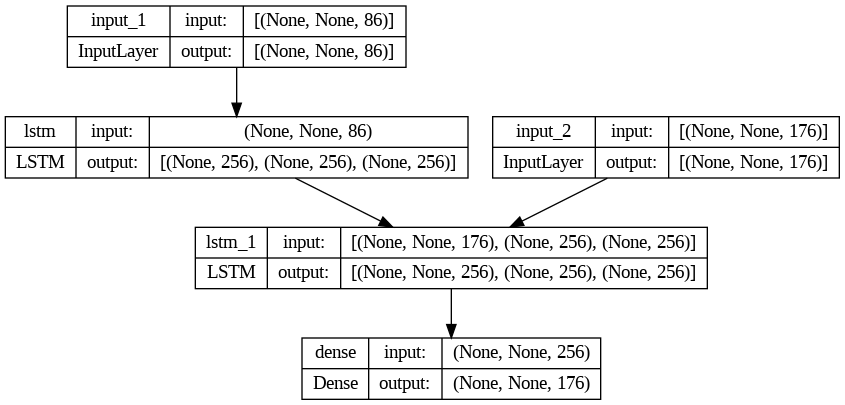

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(training_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)   # plot model

In [23]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode= 'max', verbose=1, patience= 5)

In [29]:
#Compiling
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')#Training
history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)
training_model.save('training_model.h5')

Epoch 1/1000
2/2 [==============================] - 4s 937ms/step - loss: 0.6726 - accuracy: 0.2037 - val_loss: 1.8153 - val_accuracy: 0.0463
Epoch 2/1000
2/2 [==============================] - 0s 112ms/step - loss: 0.6865 - accuracy: 0.2060 - val_loss: 1.8590 - val_accuracy: 0.0509
Epoch 3/1000
2/2 [==============================] - 0s 111ms/step - loss: 0.6824 - accuracy: 0.2049 - val_loss: 1.8130 - val_accuracy: 0.0417
Epoch 4/1000
2/2 [==============================] - 0s 108ms/step - loss: 0.6808 - accuracy: 0.2025 - val_loss: 1.8361 - val_accuracy: 0.0324
Epoch 5/1000
2/2 [==============================] - 0s 108ms/step - loss: 0.6704 - accuracy: 0.1991 - val_loss: 1.8416 - val_accuracy: 0.0463
Epoch 6/1000
2/2 [==============================] - 0s 104ms/step - loss: 0.6833 - accuracy: 0.2049 - val_loss: 1.8342 - val_accuracy: 0.0509
Epoch 7/1000
2/2 [==============================] - 0s 106ms/step - loss: 0.6890 - accuracy: 0.1956 - val_loss: 1.8453 - val_accuracy: 0.0417
Epoch 

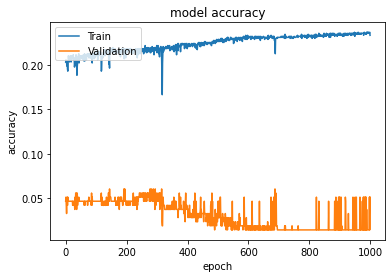

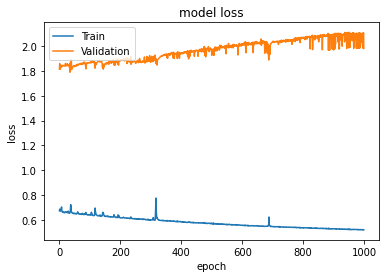

In [30]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Predictions

In [ ]:


from keras.models import load_model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)
     


In [ ]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
     

In [ ]:


decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
     


In [ ]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
     

In [ ]:
from keras.models import load_model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
          
          #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token

          #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
             stop_condition = True
          #Stop if hit max length or found the stop token
                 
          #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.
          
          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence
     

In [ ]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  #Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, How can I help you?\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)
  
  #Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
    
  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix

  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
    
#Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
chatbot = ChatBot()

In [ ]:
chatbot.start_chat()

1/1 [==============================] - 0s 22ms/step
